In [1]:
from periodicLatticeSolver import PeriodicLatticeSolver
from minimizer import Minimizer
import numpy as np
from FloorPlanClass import FloorPlan
from plotter import Plotter
PLS = PeriodicLatticeSolver(200, .02)
PLS.add_Injector()

L1 = PLS.Variable('L1', varMin=.01, varMax=.5)
L2= PLS.Variable('L2', varMin=.01, varMax=.5)
L3 =PLS.Variable('L3', varMin=.01, varMax=.5)
L4= PLS.Variable('L4', varMin=.01, varMax=.5)

Bp1 = PLS.Variable('Bp1', varMin=.1, varMax=.45)
Bp2 = PLS.Variable('Bp2', varMin=.1, varMax=.45)
Bp3 = PLS.Variable('Bp3', varMin=.1, varMax=.45)
Bp4 = PLS.Variable('Bp4', varMin=.1, varMax=.45)

rp1 = PLS.Variable('rp1', varMin=.01, varMax=.03)
rp2 = PLS.Variable('rp2', varMin=.01, varMax=.03)
rp3 = PLS.Variable('rp3', varMin=.01, varMax=.03)
rp4 = PLS.Variable('rp4', varMin=.01, varMax=.03)

r0=1#PLS.Variable('r0',varMin=1,varMax=1.25)
TL1=PLS.Variable('TL1',varMin=.5,varMax=1.5)
TL2=PLS.Variable('TL2',varMin=.5,varMax=1.5)


PLS.set_Track_Length(TL1=TL1,TL2=TL2)
PLS.begin_Lattice()

PLS.add_Bend(np.pi, r0, .45)
#PLS.add_Drift(L=.03)
PLS.add_Lens(L4, Bp4, rp4)
PLS.add_Drift()
PLS.add_Combiner()
PLS.add_Drift()
PLS.add_Lens(L1, Bp1,rp1)
#PLS.add_Drift(L=.03)
PLS.add_Bend(np.pi, r0, .45)
#PLS.add_Drift(L=.03)
PLS.add_Lens(L2, Bp2, rp2)
PLS.add_Drift()
PLS.add_Lens(L3, Bp3, rp3)
#PLS.add_Drift(L=.03)
PLS.end_Lattice()

84 48
Lattice model completed


In [36]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from periodicLatticeSolver import PeriodicLatticeSolver
import multiprocessing as mp
import time
import scipy.optimize as spo
from FloorPlanClass import FloorPlan
from tqdm import tqdm


# TODO: DEAL WITH FLOORPLAN BETTER?


class Solution():
    # An object to hold onto the solution generated with the object PlotSweep. There will be many of these
    def __init__(self):
        self.geneticSolX = None  # to hold the solution object
        self.geneticSolFitness = None  # to hold the solution object
        self.localMinSolX = None
        self.localMinSolFitness = None
        self.bounds = None  # list to hold the bounds of the solution
        self.args = None  # to hold the optimal arguments of the solution.
        self.index = None  # the index of the solution corresponding to the index of the input data
        self.args = None  # the sympy arguments that generated this solution
        self.tunex = None  # tune in the x plane
        self.tuney = None  # tune in the y plane
        self.tracex = None  # trace of transfer matrix in x plane
        self.tracey = None  # trace of transfer matrix in y plane
        self.beta = [None, None]  # List to hold arrays of beta function in x and y plane
        self.env = [None, None]  # List of the arrays of the envelope of the beta function in the x and y plane.
        self.eta = None  # to hold array of eta functions, only x plane of course
        self.zArr = None  # to hold the zArr for this solution.
        self.emittance = [None, None]  # to hold the emittance
        self.resonanceFactx = None  # the array of resonance factors in the x plane. closer to zero is better
        self.resonanceFacty = None  # the array of resonance factors in the x plane. closer to zero is better
        self.lengthList = []  # List to hold the length of each element in the lattice
        self.totalLengthList = []  # List to hold the cumulative length of each element in the list
        self.Lo = None  # the optimal object length of the injection system. Distance from collector focus to beginnig
        # of shaper lens
        self.Lm = None  # the optimal magnet length of the injection system
        self.Li = None  # the optimal image length. The distance from the end of the magnet to the focus at the combiner
        self.mag = None  # injector magnification for optimal lengths
        self.sOffset=None #the optimal offset distance of the collector element
        self.fracParticlesx=None
        self.fracParticlesy=None
        self.survivingParticles=[] #list to hold particles that survive in the lattice



class Evolution():
    def __init__(self, minimizer):
        self.minimizer = minimizer
        self.popPerDimension = None
        self.population = None
        self.mut = None
        self.minBound = None
        self.maxBound = None
        self.crossPop = None
        self.dim = None
        self.iterations = None
        self.strategy = None

    def evolve_Herd(self):
        popNormArr = np.random.rand(self.population,
                                    self.dim)  # normalized array of member's parameters in population. Values are 0 to 1,
        # it will be massaged to have the correct bounds
        popArr = self.minBound + popNormArr * (
                self.maxBound - self.minBound)  # reshape each member to respect the bounds
        fitnessList = []  # to store the fitness of each member

        floorPlan = FloorPlan(self.minimizer.PLS)
        for member in popArr:
            fitnessList.append(self.minimizer.cost_Function(member, False, floorPlan))
        fitnessArr = np.asarray(fitnessList)
        mostFitIndex = np.argmin(fitnessArr)
        mostFitFitness = fitnessArr[mostFitIndex]  # the most fit (lowest cost) member of the population
        mostFitArgs = popArr[mostFitIndex]
        inputArr = np.column_stack((popArr, fitnessArr))
        costList = []
        for k in tqdm(range(self.iterations)):
            outputArr = self.evolve_One_Generation(inputArr, floorPlan)
            popArr = outputArr[:, :-1]
            fitnessArr = outputArr[:, -1]
            if np.min(fitnessArr) < mostFitFitness:
                mostFitFitness = np.min(fitnessArr)
                mostFitIndex = np.argmin(fitnessArr)
                mostFitArgs = popArr[mostFitIndex]
            costList.append(mostFitFitness)
        return mostFitArgs, mostFitFitness, costList

    def parallel_Wrapper(self, resultsList):
        np.random.seed()
        minArgs, minCost, costList = self.evolve_Herd()
        resultsList.append([minArgs, minCost, costList])

    def evolve_To_Minimum(self, mut, crossPop, iterations, population, herds, strategy):

        if population < 4:
            raise Exception('THERE NEEDS TO BE AT LEAST 4 MEMBERS IN THE POPULATION')
        if herds == None:
            herds = mp.cpu_count()
        bounds = self.minimizer.sol.bounds
        self.mut = mut
        self.crossPop = crossPop
        self.dim = len(bounds)  # dimension of parameter space
        self.population = population
        self.minBound, self.maxBound = np.asarray(bounds).T  # arry of upper and lower bounds
        self.iterations = iterations
        self.strategy = strategy
        minArgs = None
        minCost = None
        costList = None
        if herds == 1:
            minArgs, minCost, costList = self.evolve_Herd()
        jobsList = []
        resultsList = mp.Manager().list()
        if herds != 1:
            for i in range(herds):
                proc = mp.Process(target=self.parallel_Wrapper, args=(resultsList,))
                proc.start()
                time.sleep(.1)
                jobsList.append(proc)
            for job in jobsList:
                job.join()
            resultsList = list(resultsList)
            temp = []
            temp1 = []
            for item in resultsList:
                temp.append(item[0])
                temp1.append(item[1])
            minArgs = temp[np.argmin(np.asarray(temp1))]
            minCost = np.min(np.asarray(temp1))

            temp2 = []
            for item in resultsList:
                temp2.append(item[2])
            print('minCost for each thread: ', np.asarray(temp2)[:, -1])
            costList = np.amin(np.asarray(temp2), axis=0)

        if iterations >= 50:
            plt.plot(costList[25:])
            plt.show()
        return minArgs, minCost

    def evolve_One_Generation(self, inputArr, floorPlan):
        popArr = inputArr[:, :-1]
        fitnessArr = inputArr[:, -1]
        indexArr = np.arange(popArr.shape[0])
        for j in range(indexArr.shape[0]):
            if self.strategy == 'best/1':
                a = popArr[np.argmin(fitnessArr)]
                bcInices = np.random.choice(np.delete(indexArr, j), 2, replace=False)
                b, c = popArr[bcInices]
                mutant = np.clip(a + (b - c) * self.mut, self.minBound, self.maxBound)
            elif self.strategy == 'rand/1':
                abcInices = np.random.choice(np.delete(indexArr, j), 3, replace=False)
                a, b, c = popArr[abcInices]
                mutant = np.clip(a + (b - c) * self.mut, self.minBound, self.maxBound)
            elif self.strategy == 'current-to-best/1':
                F = .3  # auxiliary mutation factor
                a = popArr[np.argmin(fitnessArr)]
                bcInices = np.random.choice(np.delete(indexArr, j), 2, replace=False)
                b, c = popArr[bcInices]
                mutant = np.clip(popArr[j] + F * (a - popArr[j]) + (b - c) * self.mut, self.minBound, self.maxBound)
            else:
                raise Exception('NO VALID MUTATION STRATEGY SELECTED')
            crossIndices = np.random.rand(self.dim) < self.crossPop
            trial = popArr[j].copy()
            trial[crossIndices] = mutant[crossIndices]
            fitness = self.minimizer.cost_Function(trial, False, floorPlan)
            if fitness < fitnessArr[j]:
                fitnessArr[j] = fitness
                popArr[j] = trial
        return np.column_stack((popArr, fitnessArr))


class Minimizer():
    def __init__(self, PLS, numSteps=5):
        self.PLS = PLS
        self.numPoints = 250  # number of points in the beta array
        self.a_Sigmoid_Trace = 100  # a guess at a value that gives a good sigmoid for trace.
        #testing shows around 100
        self.a_Sigmoid_Env=(self.numPoints*.02)*10 #a guess at good value of sigmoid factor. A reasonable value for the
            #sum mulitplied by a factor
        self.traceMax = 1.9  # rather than punishing for trace being above 2
        self.sol = None  # the final solution
        self.numSolutions = None  # number of solutions



    def cost_Function(self, x, Print, floorPlan):
        # this function returns the 'cost' of a particular point in parameter space. The goal is to minimize this cost.
        # The cost function varies continuously everywhere in the space. The derivative is not continuous. This is probably
        # fine because genetic algorithm doesn't use the derivative. I think newton's method works as well with discontinuous
        # derivatives
        # The steps are as follows
        # 1: If the floorplan violates a contraint it gives a value greater than 4. The total cost is then this value. If less
        # than 4 go to the next step
        # 2: compute the trace. If it's greater than self.traceMax confine the result between a value of self.traceMax
        # and 4. If not go to the next step
        # 3: count the number of clipped particle. compute the total envelope sum of the unclipped particles.
        #  constrain the sum between 0 and 1. the cost is then the number of clipped particles plus the contrained
        #  envelope sum divided by number of particles plus 1. This is then scaled to be betweeon 0 and self.traceMax
        layOutCost = floorPlan.calculate_Cost(args=x, offset=4)  # cost from floor plan
        if Print == True:
            print('-----ENTERED COST FUNCTION-----------------------------------------------------------------')
        if layOutCost > 4:  # minimum value of layout cost is 4
            if Print == True:
                print('Floor layout conditions violated')
                print('layout cost: ' + str(layOutCost))
                print('Arguments are (below)')
                print(x)
            return layOutCost
        else:
            xLattice = x[:-3]  # the lattice parameters
            xInjector = x[-3:]  # the injector parameters
            M = self.PLS.MTotFunc(*xLattice)
            tracex = np.abs(np.trace(M[:2, :2]))
            tracey = np.abs(np.trace(M[3:, 3:]))
            if tracey >= self.traceMax or tracex >= self.traceMax:
                cost = (tracey + tracex)  # minimum value is self.traceMax
                if Print == True:
                    print('Trace is greater than maximum.Values are (x,y): ' + str(tracex) + ' ' + str(tracey))
                return self.sigmoid_Trace(cost)

            else:
                totalLengthList = self.PLS.totalLengthListFunc(*xLattice)
                envList,emittanceArrList=self.make_Envelope_And_Emittance_List(x, totalLengthList)
                numClippedx,numClippedy=self.find_Clipped_Particles(totalLengthList, xLattice, envList)



                #find the sum of the envelope but normalize to the number of particles
                envSum=0
                if numClippedx<self.PLS.injector.numParticlesx or numClippedy<self.PLS.injector.numParticlesy: #only
                    #bother if there are surviving particles
                    #print('here')
                    for i in range(len(self.PLS.injector.particles)):
                        envX=0
                        envY=0
                        particle=self.PLS.injector.particles[i]
                        if particle.clippedx[0]==False:
                            envX = np.sum(envList[0][i])
                        if particle.clippedx[1]==False:
                            if envX!=0: #average the two x particles otherwise it will weight x plane more than y
                                envX = (np.sum(envList[1][i])+envX)/2
                            else:
                                envX=np.sum(envList[1][i])
                        envSum+=np.sqrt(envX**2+envY**2)
                    envCost=self.sigmoid_Env(envSum/(self.PLS.injector.numParticles-(numClippedx+numClippedy)))
                else:
                    envCost=0
                if numClippedx==self.PLS.injector.numParticlesx or numClippedy==self.PLS.injector.numParticlesy:
                    cost=self.traceMax #if none survive just set to maximum value of trace
                else:
                    cost=((numClippedx+numClippedy)/(self.PLS.injector.numParticles+1)+envCost)*self.traceMax
                return cost




                #if Print==True:
                #    print(envCost)
                #    print(clipCost)
                #    print(self.a_Sigmoid)
                #cost=self.sigmoid(clipCost+envCost)

    def make_Envelope_And_Emittance_List(self, x, totalLengthList):
        #returns a list of the envelopes of the particles in the x and y plane
        xLattice = x[:-3]  # the lattice parameters
        beta = self.PLS.compute_Beta_Of_Z_Array(xLattice, numpoints=self.numPoints, returZarr=False)
        eta = self.PLS.compute_Eta_Of_Z_Array(xLattice, numpoints=self.numPoints, returZarr=False)
        eta = np.abs(eta)  # the absolute value is all that really matter

        emittanceArrList = self.compute_Emittance(x, totalLengthList)  # list of two arrays where the first array
        envList = [[], []]
        for i in range(emittanceArrList[0].shape[0]):
            envx = np.sqrt(emittanceArrList[0][i] * beta[0])
            envy = np.sqrt(emittanceArrList[1][i] * beta[1])
            delta = self.PLS.injector.particles[i].delta
            envx += np.abs(delta * eta)  # as of now apetures are symmetric, the right and left are equal so to speak
            # so taking the absolute value isn't an issue. If I don't take the absolute value then I
            # need to check if an envelope is both higher or lower than the apeture and make sure to add beta
            # carefully
            envList[0].append(envx)
            envList[1].append(envy)
        return envList,emittanceArrList
    def find_Clipped_Particles(self,totalLengthList,xLattice,envList):
        numClippedx = 0
        numClippedy = 0
        for i in range(len(self.PLS.injector.particles)):
            particle=self.PLS.injector.particles[i]
            particle.clippedx=[False,False] #need to initialize to false because they may been set to true before
            particle.clippedy=False #need to initialize to false because they may been set to true before
            delta=particle.delta
            for j in range(len(self.PLS.lattice)):
                el = self.PLS.lattice[j]
                if j == 0:
                    ind1 = 0  # z array index of beginning of element. Only if it's the first element in the ring
                else:
                    ind1 = int(
                        totalLengthList[j - 1] * self.numPoints / totalLengthList[-1])+1  # z array index of the end
                    # element
                ind2 = int(totalLengthList[j] * self.numPoints / totalLengthList[-1])   # z array index of end of the
                # element. undershoot ending
                if ind2 > ind1 + 1:  # sometimes the element is very short and this doesn't make sense. Not usually, but
                    # can be true for small drift regions
                    elMaxx = np.max(envList[0][i][ind1:ind2])
                    elMaxy = np.max(envList[1][i][ind1:ind2])
                    apxL = el.apxFuncL(*xLattice)  # the size of the apeture in the x dimension on the outer side
                    apxR = el.apxFuncR(*xLattice)  # the size of the apeture in the x dimension on the inner side
                    apy = el.apyFunc(*xLattice)  # in the y dimension
                    if delta==0:
                        if (elMaxy>apxL or elMaxx>apxR) and particle.clippedx[0]==False: #if the particle's
                                # longitudinal velocity is exactly the nominal velocity then if it clips either
                                # right or left it's gone
                            particle.clippedx[0]=True #only set the first element to true,
                            particle.clippedx[1]=None #set the second to None as a safety to not counting later
                            numClippedx+=1
                    else:
                        if elMaxx>apxR and particle.clippedx[0]==False:
                            particle.clippedx[0]=True
                            numClippedx+=1
                        if elMaxx > apxL and particle.clippedx[1]==False:
                            particle.clippedx[1] = True
                            numClippedx+=1
                    if elMaxy > apy and particle.clippedy==False:  # if the envelope is clipping
                        particle.clippedy=True
                        numClippedy+=1
        return numClippedx,numClippedy
    def sigmoid_Trace(self,x):
        #this confines a value between self.traceMax and 4
        a = self.a_Sigmoid_Trace
        y=((((x - self.traceMax) - a / 2) / a) / (1 + ((x -self.traceMax) - a / 2) / a) +1)*(2/self.traceMax)+self.traceMax
        return y
    def sigmoid_Env(self,x):
        #confines a value of the envelope sum to be between 0 and 1
        a=self.a_Sigmoid_Env
        y = (x / a) / (1 + x / a)
        return y
    def trace_Env(self, x):
        # this confines the trace to a value between self.traceMax and 4
        a = 100
        return (((x - self.traceMax) - a / 2) / a) / (1 + ((x - self.traceMax) - a / 2) / a) + (1 + self.traceMax)

    def refine_Solution(self):  # to fill up parameters with values after zooming in on the local minimum. The global
        # minimum finder gives an 'unpolished' result. Here I use a robust local minimum finder to go the rest of the
        # distance. There is a polish option the differential evolution function, but it is a waste of resources to do
        # every solution since only one will need to be polished the polishing time is non negligeable.

        floorPlan = FloorPlan(self.PLS)
        # localSol = spo.minimize(self.cost_Function, self.sol.geneticSolX, bounds=self.sol.bounds,
        #                        args=(False, floorPlan),
        #                        options={'eps': 1E-12, 'maxls': 250, 'maxcor': 50})  # applying local minimum
        # reducedBounds = []
        # for i in range(len(self.sol.bounds)):
        #    Range = self.sol.bounds[i][1] - self.sol.bounds[i][0]
        #    Range = Range / 10
        #    low = localSol.x[i] - Range
        #    high = localSol.x[i] + Range
        #    reducedBounds.append((low, high))
        #

        floorPlan = FloorPlan(self.PLS)

        # def temp(x):
        #    return self.cost_Function(x, False, floorPlan)
        #
        # boundsArr = np.asarray(self.sol.bounds).T
        # fact = 1E-1
        # diffArr = fact * (boundsArr[1, :] - boundsArr[0, :]) / 2
        # args = np.asarray(self.sol.geneticSolX)
        # for i in range(100):
        #    boundsLower = args - diffArr
        #    boundsUpper = args + diffArr
        #    # trial=np.random.rand(5)*diffArr+boundsLower
        #    # trial
        #    xList = []
        #    for i in range(len(self.sol.bounds)):
        #        xList.append(np.linspace(boundsLower[i], boundsUpper[i], num=2))
        #    argsList = np.meshgrid(*xList)
        #    for i in range(len(args)):
        #        argsList[i] = argsList[i].flatten()
        #    argsArr = np.asarray(argsList).T
        #    costPrev = temp(args)
        #    costList = []
        #    for el in argsArr:
        #        costList.append(temp(el))
        #    costArr = np.asarray(costList)
        #    if np.min(costArr) >= costPrev:
        #        fact = fact / 2
        #        diffArr = fact * (boundsArr[1, :] - boundsArr[0, :]) / 2
        #    elif fact < 1E-14 or costPrev - np.min(costArr) < 1E-8:
        #        self.sol.localMinSolX = argsArr[np.argmin(costArr)]
        #        self.sol.localMinSolFitness = np.min(costArr)
        #        break
        finalArgs = self.sol.geneticSolX
        xLattice = finalArgs[:-3]
        M = self.PLS.MTotFunc(*xLattice)
        if M[0, 0] + M[1, 1] > 2 + 1E-10 or M[3, 3] + M[4, 4] > 2 + 1E-10:
            print('FINAL SOLUTION IS UNSTABLE!')
            sys.exit()
        
        self.update_Sol(finalArgs)
        print(self.sol.args, self.sol.geneticSolFitness)

    def update_Sol(self, args):

        self.sol.args = args
        xLattice = self.sol.args[:-3]
        xInjector = self.sol.args[-3:]
        M = self.PLS.MTotFunc(*xLattice)

        self.sol.tracex = np.abs(np.trace(M[:2, :2]))
        self.sol.tracey = np.abs(np.trace(M[3:, 3:]))

        self.sol.totalLengthList = self.PLS.totalLengthListFunc(*xLattice)
        temp = self.PLS.compute_Beta_Of_Z_Array(xLattice, numpoints=1000, returZarr=True)
        self.sol.zArr = temp[0]
        self.sol.beta = temp[1]
        self.sol.eta = self.PLS.compute_Eta_Of_Z_Array(xLattice, numpoints=1000, returZarr=False)
        self.sol.emittance, temp = self.compute_Emittance(self.sol.args, self.sol.totalLengthList,
                                                          returnAll=True)
        self.sol.mag, self.sol.Lo, self.sol.Lm, self.sol.Li,self.sol.sOffset = temp
        #use the largest emittance particle that isn't clipping
        envList,emittanceArrList = self.make_Envelope_And_Emittance_List(self.sol.args, self.sol.totalLengthList)
        clippedx,clippedy=self.find_Clipped_Particles(self.sol.totalLengthList, xLattice, envList)
        numParticlesx=self.PLS.injector.numParticlesx
        numParticlesy = self.PLS.injector.numParticlesy
        self.sol.fracParticlesx=(numParticlesx-clippedx)/numParticlesx
        self.sol.fracParticlesy = (numParticlesy - clippedy) / numParticlesy
        if clippedx==numParticlesx or clippedy==numParticlesy:
            if clippedx==numParticlesx:
                print('ALL PARTICLES IN X AXIS CLIPPED')
            if clippedy==numParticlesy:
                print('ALL PARTICLES IN Y AXIS CLIPPED')
            sys.exit()

        #if numClippedx==len(self.PLS.injector.particles) or numClippedy==len(self.PLS.injector.particles):
        #    print('One or more dimensions has no surviving particles!')
        #    sys.exit()
        #    # Now add unclipped particles to a list
        #for particle in self.injector.PLS.particles:
        #    if clippedXBoolList[i]==False:
        #        self.sol.survivingParticles.append(particle)
        #    if clippedYBoolList[i]==False:
        #        self.sol.survivingParticles.append(particle)
        #self.sol.fracParticlesx=1-(numClippedx/len(self.PLS.injector.particles))
        #self.sol.fracParticlesy=1-(numClippedy/len(self.PLS.injector.particles))
        maxValx=0
        maxValy=0
        maxArgx=None
        maxArgy=None
        #print(numClippedx,numClippedy)
        i=0
        for particle in self.PLS.injector.particles:
            delta=particle.delta
            if delta==0:
                if particle.clippedx[0]==False:
                    envX=np.sum(envList[0][i])
                    if envX>maxValx:
                        maxValx=envX
                        maxArgx=i
            else:
                if particle.clippedx[0]==False: #use the 'left' side, ie outer apeture limit of x. This is the smaller one
                    envX=np.sum(envList[0][i])
                    if envX>maxValx:
                        maxValx=envX
                        maxArgx=i
            if particle.clippedy==False:
                envY=np.sum(envList[1][i])
                if envY>maxValy:
                    maxValy=envY
                    maxArgy=i
            i+=1


        self.sol.emittance=[emittanceArrList[0][maxArgx],emittanceArrList[1][maxArgy]]
        self.sol.tunex = np.trapz(np.power(self.sol.beta[0], -1), x=self.sol.zArr) / (2 * np.pi)
        self.sol.tuney = np.trapz(np.power(self.sol.beta[1], -1), x=self.sol.zArr) / (2 * np.pi)
        self.sol.resonanceFactx = self.PLS.compute_Resonance_Factor(self.sol.tunex, np.arange(3) + 1)
        self.sol.resonanceFacty = self.PLS.compute_Resonance_Factor(self.sol.tuney, np.arange(3) + 1)
        envx = envList[0][maxArgx]
        envy = envList[1][maxArgy]
        self.sol.env = [envx, envy]
        print('percent particles surviving (x,y): '+str(np.round(self.sol.fracParticlesx*100,1)) +
                                       ', '+ str(np.round(100*self.sol.fracParticlesy,1)))

    def find_Beta_And_Alpha_Injection(self, args, totalLengthList):
        # finds the value of beta at the injection point
        # sign of alpha is ambigous so need to find it with slope of beta unfortunately. This compares very favourably
        # with the analytic solution
        z0 = totalLengthList[self.PLS.combinerIndex]
        beta1 = self.PLS.compute_Beta_At_Z(z0 - 1E-3, args)  # beta value of the 'left' side
        beta2 = self.PLS.compute_Beta_At_Z(z0 + 1E-3, args)  # beta value on the 'right' side
        beta = [(beta1[0] + beta2[0]) / 2, (beta1[1] + beta2[1]) / 2]  # Save resources and find beta by averaging
        slopex = (beta2[0] - beta1[0]) / 2E-3  # slope of beta in x direction
        slopey = (beta2[1] - beta1[1]) / 2E-3  # slope of beta in y direction
        alpha = [-slopex / 2, -slopey / 2]  # Remember, alpha=-(dbeta/dz)/2
        return beta + alpha  # combine the two lists

    def compute_Emittance(self, x, totalLengthList, returnAll=False):
        xLattice = x[:-3]
        xInjector = x[-3:]

        betax, betay, alphax, alphay = self.find_Beta_And_Alpha_Injection(xLattice, totalLengthList)
        emittance = [np.asarray(self.PLS.injector.epsFunc(xInjector, betax, alphax)),
                     np.asarray(self.PLS.injector.epsFunc(xInjector, betay, alphay))]
        if returnAll == True:
            # M=injector.MFunc(*injArgArr[:,minIndex])
            mag = self.PLS.injector.MFunc(*xInjector)[0, 0]
            LoOp = xInjector[0]
            LmOp = xInjector[1]
            LiOp = self.PLS.injector.LiFunc(*xInjector)
            sOffset=xInjector[2]
            return emittance, [mag, LoOp, LmOp, LiOp,sOffset]
        else:
            return emittance

    def find_Global_Min(self, mut=.5, crossPop=.5, iterations=10, herds=None,population=None, popPerDim=15, strategy='best/1'):
        # this method takes the bounds from the PLS object breaks them up into n chunks. If the chunks keyword is given
        # the space is split along its first axis into that many chunks. If slices are given the space is sliced that
        # many times along each axis. So a dim dimensional space has (slices+1)**dim chunks.
        # These chunks are then passed off to be solved in parallel. I use Process instead of Pool, probably should have
        # used pool, I think it splits the bounds up for me, but I've had more luck with Process
        t = time.time()
        self.sol = Solution()
        bounds = []  # list to hold list of the bounds  [[x1,x2],[y1,y2],etc.]
        for var in self.PLS.VOList:  # get the bounds from each Variable object in the lattice
            bounds.append([var.varMin, var.varMax])

        # add injector arguments now.
        floorPlan = FloorPlan(self.PLS)
        temp = [[floorPlan.LoMin, floorPlan.LoMax]]  # object distance of injector
        bounds.extend(temp)
        temp = [[floorPlan.LmMin, floorPlan.LmMax]]  # magnet length of injector
        bounds.extend(temp)
        temp=[[self.PLS.injector.sOffsetMin,self.PLS.injector.sOffsetMax]]
        bounds.extend(temp)

        self.sol.bounds = bounds
        if population == None:
            population = popPerDim * len(self.sol.bounds)
        evolver = Evolution(self)
        self.sol.geneticSolX, self.sol.geneticSolFitness = evolver.evolve_To_Minimum(mut, crossPop, iterations,
                                                                                     population, herds, strategy)
        print(self.sol.geneticSolX, self.sol.geneticSolFitness)
        self.refine_Solution()
        print('done')
        t = time.time() - t
        print('Total time ' + str(int(t / 60)) + ' minutes and ' + str(int(t - 60 * int(t / 60))) + ' seconds')

100%|██████████| 50/50 [02:21<00:00,  2.84s/it]


minCost for each thread:  [4.00000225 1.77729369 1.80914521 1.80232026 1.83265233 1.84379264
 1.73461779 1.83299253 1.7923266  1.80815789 1.78826089 1.79603979]


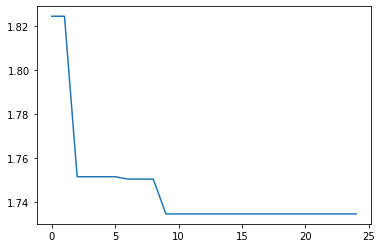

[0.06764093 0.25212916 0.49218828 0.25973387 0.250915   0.39369397
 0.19010654 0.18680861 0.02249008 0.02482211 0.0201711  0.01616136
 0.51318127 1.16839714 0.1634442  0.09783148 0.03288493] 1.7346177916020509
percent particles surviving (x,y): 8.3, 8.3
[0.06764093 0.25212916 0.49218828 0.25973387 0.250915   0.39369397
 0.19010654 0.18680861 0.02249008 0.02482211 0.0201711  0.01616136
 0.51318127 1.16839714 0.1634442  0.09783148 0.03288493] 1.7346177916020509
done
Total time 2 minutes and 22 seconds


In [38]:
minimizer=Minimizer(PLS)
minimizer.find_Global_Min(popPerDim=100,iterations=50,herds=12)

In [17]:
floorPlan=FloorPlan(PLS)
floorPlan.show_Floor_Plan(sol=minimizer.sol)
floorPlan.calculate_Cost()

TypeError: _lambdifygenerated() argument after * must be an iterable, not NoneType

In [16]:
plotter=Plotter(PLS)
plotter.plot(sol=minimizer.sol)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
floorPlan=FloorPlan(PLS)
args=[.5,.5,.5,.5,1,.2,.2,0]
floorPlan.build(args)
floorPlan.calculate_Cost()
floorPlan.show_Floor_Plan(args=args)

In [ ]:
plotter=Plotter(PLS)
plotter.plot(sol=minimizer.sol)

In [ ]:
floorPlan=FloorPlan(PLS)
floorPlan.show_Floor_Plan(sol=minimizer.sol)
floorPlan.calculate_Cost()